In [2]:
##Agenda
#Pooling Layer in CNN
# Install required packages first
# !pip install kaggle kagglehub pandas pyunpack patool

import os
import shutil
import zipfile
import tempfile
from pathlib import Path
from google.colab import files as colab_files
import kagglehub

# ============================================
# SIMPLE KAGGLE TO DRIVE DOWNLOADER
# ============================================

def download_kaggle_to_drive(kaggle_path, drive_folder, unzip=True, cleanup=True):
    """
    Simple function to download Kaggle dataset to Google Drive

    Args:
        kaggle_path: Kaggle dataset path (e.g., "username/dataset-name" or full URL)
        drive_folder: Google Drive destination folder path
        unzip: Whether to unzip files automatically
        cleanup: Whether to delete temporary files

    Returns:
        Path to downloaded files in Google Drive
    """

    print(f"🚀 Starting download: {kaggle_path}")
    print(f"📁 Destination: {drive_folder}")

    # Step 1: Extract kaggle handle from input
    def get_kaggle_handle(input_path):
        """Extract kaggle handle from various input formats"""
        import re

        # Remove any query parameters
        input_path = input_path.split('?')[0]

        # Pattern to match kaggle dataset URLs
        patterns = [
            r'kaggle\.com/(?:datasets|competitions|codes)/([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)',
            r'^([a-zA-Z0-9\-_]+/[a-zA-Z0-9\-_]+)$'
        ]

        for pattern in patterns:
            match = re.search(pattern, input_path)
            if match:
                return match.group(1)

        # If no pattern matches, return as-is
        return input_path

    # Get clean kaggle handle
    kaggle_handle = get_kaggle_handle(kaggle_path)
    print(f"🔍 Kaggle handle: {kaggle_handle}")

    # Step 2: Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive mounted")

        # Ensure drive folder is in the correct path
        if not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab - ensure drive_folder is correct path")

    # Create destination folder
    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Created destination folder: {drive_folder}")

    # Step 3: Download from Kaggle
    try:
        print("⬇️  Downloading from Kaggle...")
        download_path = kagglehub.dataset_download(kaggle_handle)
        print(f"✅ Downloaded to: {download_path}")
    except Exception as e:
        print(f"❌ Kaggle download failed: {e}")

        # Try alternative method
        try:
            import subprocess
            import tempfile

            print("🔄 Trying alternative download method...")
            temp_dir = tempfile.mkdtemp()

            # Use kaggle CLI
            result = subprocess.run(
                ["kaggle", "datasets", "download", "-d", kaggle_handle, "-p", temp_dir],
                capture_output=True,
                text=True
            )

            if result.returncode == 0:
                # Find the downloaded file
                files = os.listdir(temp_dir)
                zip_files = [f for f in files if f.endswith('.zip')]

                if zip_files:
                    download_path = os.path.join(temp_dir, zip_files[0])
                    print(f"✅ Downloaded zip file: {download_path}")
                else:
                    download_path = temp_dir
                    print(f"✅ Downloaded to directory: {download_path}")
            else:
                print(f"❌ Alternative method failed: {result.stderr}")
                return None

        except Exception as e2:
            print(f"❌ All download methods failed: {e2}")
            return None

    # Step 4: Process and copy files
    print("\n📊 Processing files...")

    def copy_files(source, destination):
        """Copy files from source to destination"""
        if os.path.isfile(source):
            # Single file
            shutil.copy2(source, destination)
            return 1
        else:
            # Directory
            count = 0
            for item in os.listdir(source):
                source_path = os.path.join(source, item)
                dest_path = os.path.join(destination, item)

                if os.path.isdir(source_path):
                    shutil.copytree(source_path, dest_path, dirs_exist_ok=True)
                    # Count files in subdirectory
                    for root, dirs, files in os.walk(source_path):
                        count += len(files)
                else:
                    shutil.copy2(source_path, dest_path)
                    count += 1
            return count

    # Check if download is a zip file
    if os.path.isfile(download_path) and download_path.endswith('.zip') and unzip:
        print(f"📦 Extracting zip file: {os.path.basename(download_path)}")

        # Create extraction directory
        extract_dir = os.path.join(drive_folder, "extracted")
        os.makedirs(extract_dir, exist_ok=True)

        # Extract zip
        try:
            with zipfile.ZipFile(download_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

            # Count extracted files
            extracted_count = 0
            for root, dirs, files in os.walk(extract_dir):
                extracted_count += len(files)

            print(f"✅ Extracted {extracted_count} files to: {extract_dir}")

            # Move files from extracted folder to main folder
            for item in os.listdir(extract_dir):
                source = os.path.join(extract_dir, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isdir(source):
                    shutil.move(source, dest)
                else:
                    shutil.move(source, dest)

            # Remove empty extract directory
            os.rmdir(extract_dir)

        except Exception as e:
            print(f"❌ Failed to extract zip: {e}")
            print("📄 Copying zip file as-is...")
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))

    else:
        # Copy files directly
        if os.path.isfile(download_path):
            # Single file
            shutil.copy2(download_path, os.path.join(drive_folder, os.path.basename(download_path)))
            print(f"✅ Copied file: {os.path.basename(download_path)}")
        else:
            # Directory
            copied_count = copy_files(download_path, drive_folder)
            print(f"✅ Copied {copied_count} files")

    # Step 5: Cleanup
    if cleanup:
        try:
            if os.path.isfile(download_path):
                os.remove(download_path)
            else:
                shutil.rmtree(download_path)
            print("🧹 Cleaned up temporary files")
        except Exception as e:
            print(f"⚠️  Could not clean up temp files: {e}")

    # Step 6: Show summary
    print("\n" + "="*50)
    print("✅ DOWNLOAD COMPLETE!")
    print("="*50)

    # List files in destination
    print(f"\n📁 Files in {drive_folder}:")
    files_list = os.listdir(drive_folder)
    for i, file in enumerate(files_list[:20]):  # Show first 20 files
        file_path = os.path.join(drive_folder, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"  {i+1:2d}. {file} ({size:,} bytes)")
        else:
            print(f"  {i+1:2d}. {file}/ (folder)")

    if len(files_list) > 20:
        print(f"  ... and {len(files_list) - 20} more items")

    print(f"\n📍 Total files/folders: {len(files_list)}")

    return drive_folder

# ============================================
# UPLOAD FROM COMPUTER FUNCTION
# ============================================

def upload_to_drive(local_folder=None, drive_folder=None):
    """
    Upload files from local computer to Google Drive

    Args:
        local_folder: If None, upload via Colab file dialog
        drive_folder: Google Drive destination folder
    """

    print("💻 UPLOAD FROM COMPUTER")
    print("="*50)

    # Mount Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        if drive_folder and not drive_folder.startswith('/content/drive'):
            drive_folder = f"/content/drive/MyDrive/{drive_folder.lstrip('/')}"
    except ImportError:
        print("⚠️  Not in Google Colab")
        if not drive_folder:
            drive_folder = input("Enter Google Drive folder path: ").strip()

    if not drive_folder:
        drive_folder = "/content/drive/MyDrive/Uploads"

    os.makedirs(drive_folder, exist_ok=True)
    print(f"📁 Destination: {drive_folder}")

    uploaded_files = []

    if local_folder:
        # Upload from specified local folder
        if os.path.exists(local_folder):
            print(f"📤 Uploading from local folder: {local_folder}")

            for item in os.listdir(local_folder):
                source = os.path.join(local_folder, item)
                dest = os.path.join(drive_folder, item)

                if os.path.isfile(source):
                    shutil.copy2(source, dest)
                    uploaded_files.append(item)
                    print(f"  ✅ {item}")
                else:
                    shutil.copytree(source, dest, dirs_exist_ok=True)
                    uploaded_files.append(f"{item}/")
                    print(f"  ✅ {item}/")
        else:
            print(f"❌ Local folder not found: {local_folder}")
            return None

    else:
        # Upload via Colab file dialog
        try:
            print("📤 Please select files to upload...")
            uploaded = colab_files.upload()

            if uploaded:
                for filename, content in uploaded.items():
                    dest_path = os.path.join(drive_folder, filename)

                    # Save file
                    with open(dest_path, 'wb') as f:
                        f.write(content)

                    uploaded_files.append(filename)
                    print(f"  ✅ {filename}")
            else:
                print("⚠️  No files selected")
                return None

        except Exception as e:
            print(f"❌ Upload failed: {e}")
            return None

    print(f"\n✅ Uploaded {len(uploaded_files)} files to: {drive_folder}")
    return drive_folder

# ============================================
# COMBINED FUNCTION WITH MENU
# ============================================

def data_transfer_tool():
    """
    Main function with menu to choose between Kaggle download or local upload
    """

    print("""
    ╔═══════════════════════════════════════╗
    ║       DATA TRANSFER TOOL              ║
    ║   Kaggle → Drive  or  Local → Drive   ║
    ╚═══════════════════════════════════════╝
    """)

    while True:
        print("\n" + "="*50)
        print("MAIN MENU")
        print("="*50)
        print("1. 📥 Download from Kaggle to Google Drive")
        print("2. 💻 Upload from computer to Google Drive")
        print("3. 🚪 Exit")

        choice = input("\nSelect option (1-3): ").strip()

        if choice == "1":
            print("\n📥 KAGGLE TO GOOGLE DRIVE")
            print("-"*30)

            # Get kaggle path
            print("\nEnter Kaggle dataset (any format):")
            print("Examples:")
            print("  - https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024")
            print("  - jekiwantaufik/west-java-2014-2024")

            kaggle_path = input("\nKaggle dataset: ").strip()

            if not kaggle_path:
                print("❌ No input provided")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Kaggle_Datasets"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Options
            unzip_choice = input("\nUnzip files? (yes/no) [yes]: ").strip().lower()
            unzip = not unzip_choice or unzip_choice in ['yes', 'y', '1']

            cleanup_choice = input("Cleanup temporary files? (yes/no) [yes]: ").strip().lower()
            cleanup = not cleanup_choice or cleanup_choice in ['yes', 'y', '1']

            # Download
            download_kaggle_to_drive(kaggle_path, drive_folder, unzip, cleanup)

        elif choice == "2":
            print("\n💻 UPLOAD FROM COMPUTER")
            print("-"*30)

            # Get source
            print("\nChoose source:")
            print("1. Upload via file dialog (Colab)")
            print("2. Specify local folder path")

            source_choice = input("\nSelect (1 or 2): ").strip()

            if source_choice == "1":
                local_folder = None
            elif source_choice == "2":
                local_folder = input("\nEnter local folder path: ").strip()
                if not os.path.exists(local_folder):
                    print(f"❌ Folder not found: {local_folder}")
                    continue
            else:
                print("❌ Invalid choice")
                continue

            # Get drive folder
            default_drive = "/content/drive/MyDrive/Uploads"
            drive_folder = input(f"\nGoogle Drive folder [{default_drive}]: ").strip()
            if not drive_folder:
                drive_folder = default_drive

            # Upload
            upload_to_drive(local_folder, drive_folder)

        elif choice == "3":
            print("👋 Goodbye!")
            break

        else:
            print("❌ Invalid choice")

        input("\nPress Enter to continue...")

# ============================================
# QUICK USAGE EXAMPLES
# ============================================

# Example 1: Direct Kaggle download
def example_kaggle():
    """Example: Download a Kaggle dataset"""
    download_kaggle_to_drive(
        kaggle_path="https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024",
        drive_folder="/content/drive/MyDrive/Datasets/WestJava",
        unzip=True,
        cleanup=True
    )

# Example 2: Direct upload
def example_upload():
    """Example: Upload from computer"""
    upload_to_drive(
        local_folder=None,  # Will use Colab file dialog
        drive_folder="/content/drive/MyDrive/Uploads"
    )

# Example 3: Upload specific folder
def example_upload_folder():
    """Example: Upload specific folder"""
    upload_to_drive(
        local_folder="/path/to/your/local/folder",
        drive_folder="/content/drive/MyDrive/MyProject/Data"
    )

# ============================================
# RUN THE TOOL
# ============================================

if __name__ == "__main__":
    # Run the interactive tool
    data_transfer_tool()

    # Or use directly:
    # download_kaggle_to_drive("username/dataset", "/content/drive/MyDrive/MyFolder")


    ╔═══════════════════════════════════════╗
    ║       DATA TRANSFER TOOL              ║
    ║   Kaggle → Drive  or  Local → Drive   ║
    ╚═══════════════════════════════════════╝
    

MAIN MENU
1. 📥 Download from Kaggle to Google Drive
2. 💻 Upload from computer to Google Drive
3. 🚪 Exit

Select option (1-3): 1

📥 KAGGLE TO GOOGLE DRIVE
------------------------------

Enter Kaggle dataset (any format):
Examples:
  - https://www.kaggle.com/datasets/jekiwantaufik/west-java-2014-2024
  - jekiwantaufik/west-java-2014-2024

Kaggle dataset: https://www.kaggle.com/datasets/samuelcortinhas/apples-or-tomatoes-image-classification

Google Drive folder [/content/drive/MyDrive/Kaggle_Datasets]: 3

Unzip files? (yes/no) [yes]: no
Cleanup temporary files? (yes/no) [yes]: no
🚀 Starting download: https://www.kaggle.com/datasets/samuelcortinhas/apples-or-tomatoes-image-classification
📁 Destination: 3
🔍 Kaggle handle: samuelcortinhas/apples-or-tomatoes-image-classification
Mounted at /content/driv

100%|██████████| 2.33M/2.33M [00:00<00:00, 114MB/s]

Extracting files...
✅ Downloaded to: /root/.cache/kagglehub/datasets/samuelcortinhas/apples-or-tomatoes-image-classification/versions/1

📊 Processing files...


✅ Copied 391 files

✅ DOWNLOAD COMPLETE!

📁 Files in /content/drive/MyDrive/3:
   1. earthquake_data_tsunami.csv (40,942 bytes)
   2. heart_disease_uci.csv (79,346 bytes)
   3. train/ (folder)
   4. test/ (folder)

📍 Total files/folders: 4

Press Enter to continue...3

MAIN MENU
1. 📥 Download from Kaggle to Google Drive
2. 💻 Upload from computer to Google Drive
3. 🚪 Exit

Select option (1-3): 3
👋 Goodbye!


In [3]:
import tensorflow as tf;
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from keras.layers import BatchNormalization,Dropout

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Data Loading
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Apples_tomatos_classification_dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 294 files belonging to 2 classes.


In [10]:
validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Apples_tomatos_classification_dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256)
)

Found 97 files belonging to 2 classes.


In [14]:
#before training we will have to do the normalization
def process(image,label):
  image=tf.cast(image/255,tf.float32)
  return image,label
train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)
print(f"Train data normalization information:{train_ds}")
print(f"Validation data normalization information:{validation_ds}")

Train data normalization information:<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation data normalization information:<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [28]:
model=Sequential()
##first step
model.add(
    Conv2D(
        32,
        kernel_size=(3,3),
        padding='valid',
        activation='relu',
        input_shape=(256,256,3)
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
##second
model.add(
    Conv2D(
        64,
        kernel_size=(3,3),
        padding='valid',
        activation='relu'
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=2,pool_size=(2,2),padding='valid'))
#third
model.add(
    Conv2D(
        128,
        kernel_size=(3,3),
        activation='relu',
        padding='valid'
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
#forth
model.add(Flatten())
#adding Dense Layer
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
#model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
history=model.fit(
    train_ds,
    epochs=5,
    validation_data=validation_ds
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 13s/step - accuracy: 0.5981 - loss: 5.1363 - val_accuracy: 0.5567 - val_loss: 0.6982
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6889 - loss: 4.9378 - val_accuracy: 0.5567 - val_loss: 0.8962
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6868 - loss: 5.4726 - val_accuracy: 0.5567 - val_loss: 0.6861
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7137 - loss: 4.3339 - val_accuracy: 0.5567 - val_loss: 1.9918
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7763 - loss: 3.5017 - val_accuracy: 0.5567 - val_loss: 4.3812


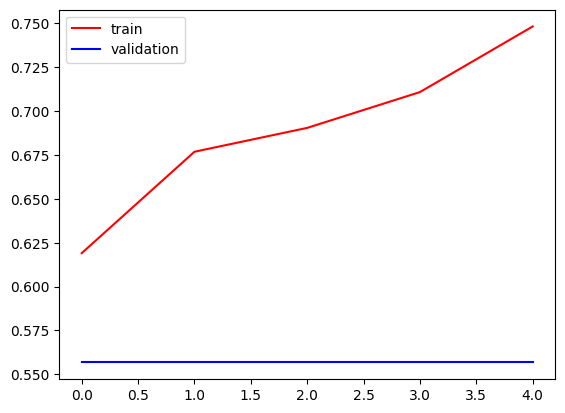

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

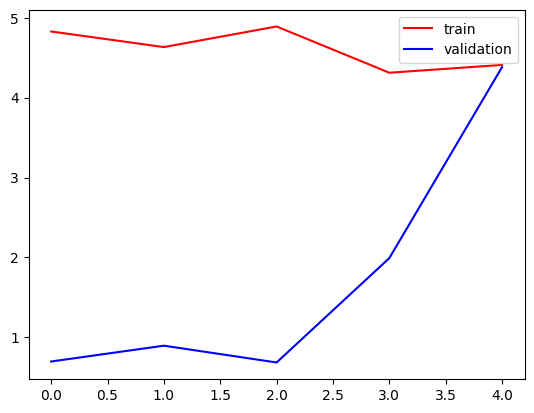

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [43]:
##Ways to reduce overfitting
'''
1.Add more data
2.Data Augmentaion
3.Dropout
4.Batch Norm
5.Reduce complexity
'''

'\n1.Add more data\n2.Data Augmentaion\n3.Dropout\n4.Batch Norm\n5.Reduce complexity\n'

array([[[ 30,  44,  67],
        [ 30,  52,  86],
        [ 34,  64, 107],
        ...,
        [ 27,  34,  43],
        [ 28,  35,  46],
        [ 34,  42,  59]],

       [[ 32,  46,  69],
        [ 33,  54,  88],
        [ 37,  65, 108],
        ...,
        [ 27,  34,  43],
        [ 28,  35,  46],
        [ 34,  42,  59]],

       [[ 36,  49,  73],
        [ 35,  56,  89],
        [ 38,  66, 108],
        ...,
        [ 28,  35,  44],
        [ 29,  36,  46],
        [ 33,  41,  58]],

       ...,

       [[ 41,  48,  67],
        [ 39,  46,  65],
        [ 31,  38,  57],
        ...,
        [ 40,  42,  49],
        [ 49,  52,  57],
        [ 26,  30,  35]],

       [[ 37,  45,  63],
        [ 33,  41,  59],
        [ 27,  35,  54],
        ...,
        [ 42,  45,  52],
        [ 53,  56,  61],
        [ 22,  25,  30]],

       [[ 45,  57,  75],
        [ 27,  39,  57],
        [ 31,  43,  60],
        ...,
        [ 23,  29,  35],
        [ 33,  39,  44],
        [ 26,  29,  34]]], dtype=uint8)
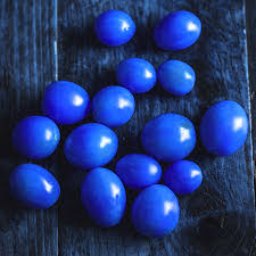

In [57]:
import cv2
test_Imag=cv2.imread('/content/drive/MyDrive/Apples_tomatos_classification_dataset/test/apples/img_p1_111.jpeg')
test_Imag1=cv2.imread('/content/drive/MyDrive/Apples_tomatos_classification_dataset/test/tomatoes/img_p1_105.jpeg')
image=cv2.resize(test_Imag1,(256,256))
image

In [61]:
test_input=image.reshape((1,256,256,3))
test_input

array([[[[ 30,  44,  67],
         [ 30,  52,  86],
         [ 34,  64, 107],
         ...,
         [ 27,  34,  43],
         [ 28,  35,  46],
         [ 34,  42,  59]],

        [[ 32,  46,  69],
         [ 33,  54,  88],
         [ 37,  65, 108],
         ...,
         [ 27,  34,  43],
         [ 28,  35,  46],
         [ 34,  42,  59]],

        [[ 36,  49,  73],
         [ 35,  56,  89],
         [ 38,  66, 108],
         ...,
         [ 28,  35,  44],
         [ 29,  36,  46],
         [ 33,  41,  58]],

        ...,

        [[ 41,  48,  67],
         [ 39,  46,  65],
         [ 31,  38,  57],
         ...,
         [ 40,  42,  49],
         [ 49,  52,  57],
         [ 26,  30,  35]],

        [[ 37,  45,  63],
         [ 33,  41,  59],
         [ 27,  35,  54],
         ...,
         [ 42,  45,  52],
         [ 53,  56,  61],
         [ 22,  25,  30]],

        [[ 45,  57,  75],
         [ 27,  39,  57],
         [ 31,  43,  60],
         ...,
         [ 23,  29,  35],
        

In [62]:
result=model.predict(test_input)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.]], dtype=float32)

In [66]:
if int(result[0][0])==0:
  print("Apple")
else:
  print("Tomato")

Apple
